In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.fft import fft2, fftshift, ifftshift

import tensorflow as tf

from scipy.integrate import simps

import sys
if not 'seaborn' in sys.modules:
    sys.path.append('/groups/turaga/home/turagas/research/')
    sys.path.append('/groups/turaga/home/turagas/anaconda3/lib/python3.5/site-packages/')
import seaborn as sns # Used only to set up plots
sns.set_context(context = 'talk')
# plt.style.use('dark_background')
# plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# create Tensorflow session
sess = tf.InteractiveSession()

In [3]:
# Setup the simulation parameters
wavelength = 0.68   # microns
NA         = 0.7    # Numerical aperture of the objective
pixelSize  = 0.1    # microns
numPixels  = 2048   # Number of pixels in the camera; keep this even
power      = 0.1    # Watts
Z0         = 376.73 # Ohms; impedance of free space

In [4]:
# Create the image plane coordinates
x = np.linspace(-pixelSize * numPixels / 2, pixelSize * numPixels / 2, num = numPixels, endpoint = True)

In [5]:
# Create the Fourier plane
dx = x[1] - x[0]    # Sampling period, microns
fS = 1 / dx         # Spatial sampling frequency, inverse microns
df = fS / numPixels # Spacing between discrete frequency coordinates, inverse microns
fx = np.arange(-fS / 2, fS / 2, step = df) # Spatial frequency, inverse microns

In [6]:
# Create the pupil, which is defined by the numerical aperture
fNA             = NA / wavelength # radius of the pupil, inverse microns
pupilRadius     = fNA / df        # pixels
pupilCenter     = numPixels / 2   # assumes numPixels is even
W, H            = np.meshgrid(np.arange(0, numPixels), np.arange(0, numPixels)) # coordinates of the array indexes
pupilMask       = 1.0*(np.sqrt((W - pupilCenter)**2 + (H - pupilCenter)**2) <= pupilRadius)

In [7]:
# Compute normalizing constant
norm_factor = simps(simps(np.abs(pupilMask)**2, dx = df), dx = df) / Z0 # A^2
print('Normalization constant:\t\t{:.4f} W'.format(np.sqrt(norm_factor)))

# Renormalize the pupil values
pupil = pupilMask * (1 + 0j)
normedPupil = pupil * np.sqrt(power / norm_factor)

new_power = simps(simps(np.abs(normedPupil)**2, dx = df), dx = df) / Z0
print('User-defined power:\t\t{:.4f} W'.format(power))
print('Power now carried by field:\t{:.4f} W'.format(new_power))

Normalization constant:		0.0940 W
User-defined power:		0.1000 W
Power now carried by field:	0.1000 W


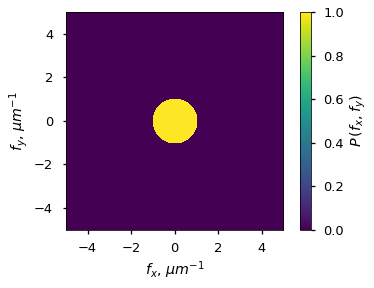

Power in pupil plane: 0.1000 W


In [8]:
# Show the pupil
ax = plt.imshow(np.abs(pupil), extent = [fx[0], fx[-1], fx[0], fx[-1]])
plt.grid(False)
cb = plt.colorbar(ax)
cb.set_label('$P \, ( f_x, f_y ) $')
plt.xlabel('$f_x$, $\mu m^{-1}$')
plt.ylabel('$f_y$, $\mu m^{-1}$')
plt.show()

# Compute the power
power_pupil = simps(simps(np.abs(normedPupil)**2, dx = df), dx = df) / Z0
print('Power in pupil plane: {:.4f} W'.format(power_pupil))

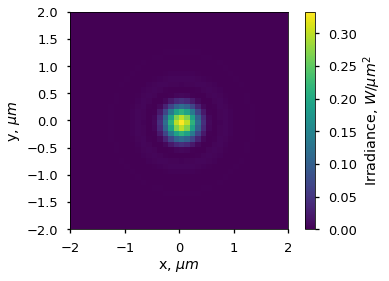

In [9]:
psf_a = fftshift(fft2(ifftshift(normedPupil))) * df**2
image = np.abs(psf_a)**2 / Z0

# Show the image plane
img = plt.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]])
cb = plt.colorbar(img)
plt.gca().set_xlim((-2, 2))
plt.gca().set_ylim((-2, 2))

plt.xlabel('x, $\mu m$')
plt.ylabel('y, $\mu m$')
cb.set_label('Irradiance, $W / \mu m^2$')
plt.grid(False)
plt.show()

In [10]:
def fftshift_tf(input,axis=1):
    split_size_right = tf.floordiv(tf.shape(input)[axis],2)
    split_sizes = [tf.shape(input)[axis]-split_size_right, split_size_right]
    pos, neg = tf.split(input,split_sizes,axis=axis)
    input = tf.concat([neg,pos],axis=axis)
    return input

def ifftshift_tf(input,axis=1):
    split_size_left = tf.floordiv(tf.shape(input)[axis],2)
    split_sizes = [split_size_left, tf.shape(input)[axis]-split_size_left]
    pos, neg = tf.split(input,2,axis=axis)
    input = tf.concat([neg,pos],axis=axis)
    return input

def fftshift2d_tf(input):
    input = fftshift_tf(input,axis=0)
    input = fftshift_tf(input,axis=1)
    return input
    
def ifftshift2d_tf(input):
    input = ifftshift_tf(input,axis=0)
    input = ifftshift_tf(input,axis=1)
    return input

In [22]:
mask_tf = tf.constant(pupilMask,dtype=tf.complex64)
pupil_tf = tf.convert_to_tensor(normedPupil,dtype=tf.complex64)
pupil_mask_tf = tf.multiply(mask_tf,pupil_tf)
psf_tf = fftshift2d_tf(tf.fft2d(ifftshift2d_tf(pupil_mask_tf)))
# psf_tf = tf.fft2d(ifftshift2d_tf(pupil_mask_tf))
# psf_tf = tf.fft2d(pupil_mask_tf)
# psf_tf = ifftshift2d_tf(pupil_mask_tf)
pupil_mask_np, psf_np = sess.run([pupil_mask_tf, psf_tf])

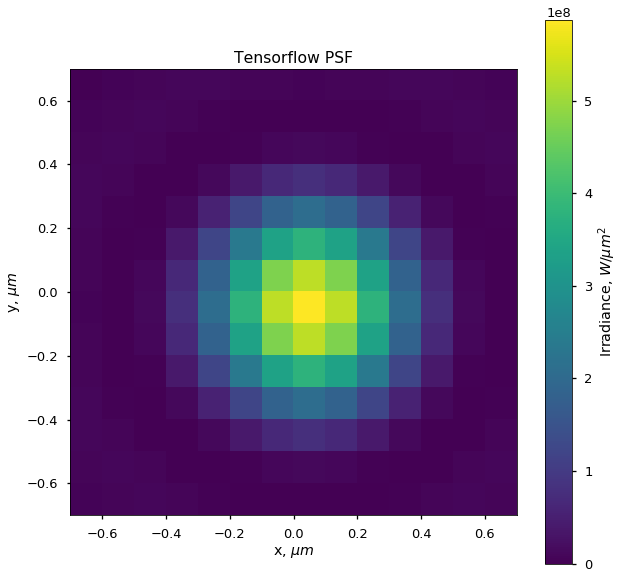

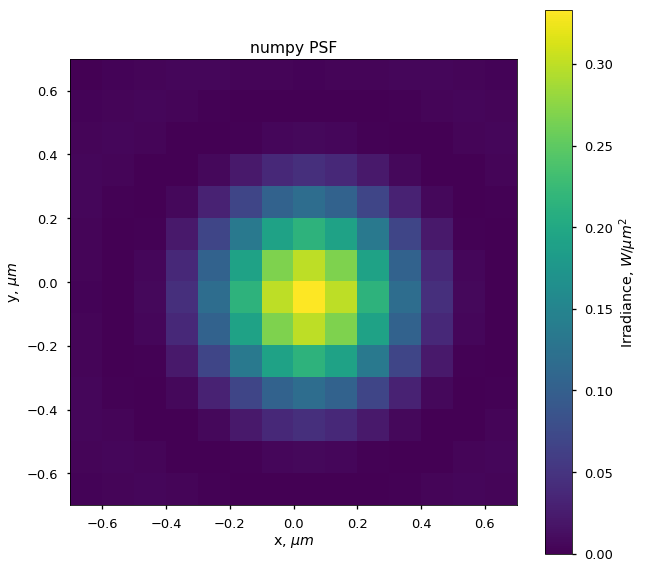

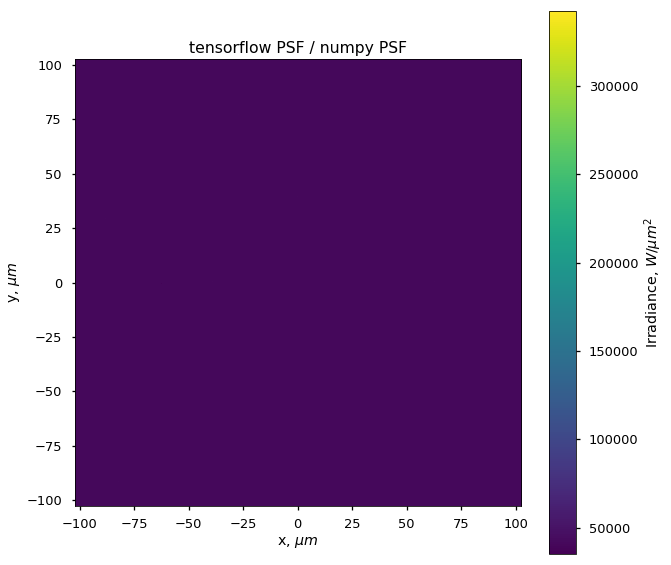

In [40]:
lim=0.7

image = np.abs(psf_np)**2 / Z0
plt.figure(figsize=(10,10))
img = plt.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]])
cb = plt.colorbar(img)
plt.gca().set_xlim((-lim, lim))
plt.gca().set_ylim((-lim, lim))
plt.title('Tensorflow PSF')

plt.xlabel('x, $\mu m$')
plt.ylabel('y, $\mu m$')
cb.set_label('Irradiance, $W / \mu m^2$')
plt.grid(False)
plt.show()

image = np.abs(psf_a)**2 / Z0
plt.figure(figsize=(10,10))
img = plt.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]])
cb = plt.colorbar(img)
plt.gca().set_xlim((-lim, lim))
plt.gca().set_ylim((-lim, lim))
plt.title('numpy PSF')

plt.xlabel('x, $\mu m$')
plt.ylabel('y, $\mu m$')
cb.set_label('Irradiance, $W / \mu m^2$')
plt.grid(False)
plt.show()


image = np.abs(psf_np).astype(np.float32) / np.abs(psf_a).astype(np.float32)
plt.figure(figsize=(10,10))
img = plt.imshow(image, interpolation='nearest', extent = [x[0], x[-1], x[0], x[-1]])
cb = plt.colorbar(img)
# plt.gca().set_xlim((-lim, lim))
# plt.gca().set_ylim((-lim, lim))
plt.title('tensorflow PSF / numpy PSF')

plt.xlabel('x, $\mu m$')
plt.ylabel('y, $\mu m$')
cb.set_label('Irradiance, $W / \mu m^2$')
plt.grid(False)
plt.show()

In [30]:
p=np.abs(psf_a)

In [32]:
p2=np.abs(psf_np)

In [33]:
p2.astype(np.fl)

dtype('float32')

In [ ]:
# Defocus from -1 micron to + 1 micron
defocusDistance = np.arange(-1, 1.1, 0.1)
defocusPSF      = np.zeros((numPixels, numPixels, defocusDistance.size))

for ctr, z in enumerate(defocusDistance):
    # Add 0j to ensure that np.sqrt knows that its argument is complex
    defocusPhaseAngle   = 1j * z * np.sqrt((2 * np.pi * NA / wavelength)**2 - KX**2 - KY**2 + 0j)
    defocusKernel       = np.exp(defocusPhaseAngle)
    defocusPupil        = pupil * defocusKernel
    defocusPSFA         = fftshift(fft2(ifftshift(defocusPupil))) * dk**2
    defocusPSF[:,:,ctr] = np.real(defocusPSFA * np.conj(defocusPSFA))

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2)

zoomWidth = 20 # pixels
indx      = [9, 14] # indexes to defocus distances to plot

# Find the maximum in the in-focus image for displaying PSF's on the correct intensity scale
maxIrradiance = np.max(defocusPSF[:,:,10])

ax0.imshow(defocusPSF[:, :, indx[0]], vmin =0, vmax = maxIrradiance, interpolation = 'nearest')
ax0.set_xlim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax0.set_ylim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax0.set_xlabel('x-position, pixels')
ax0.set_ylabel('y-position, pixels')
ax0.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[0]]))

ax1.imshow(defocusPSF[:, :, indx[1]], vmin =0, vmax = maxIrradiance, interpolation = 'nearest')
ax1.set_xlim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax1.set_ylim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax1.set_xlabel('x-position, pixels')
ax1.set_ylabel('y-osition, pixels')
ax1.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[1]]))
plt.tight_layout()
plt.show()

In [ ]:
simps(simps(np.abs(pupilMask)**2, dx = df), dx = df) / Z0

In [ ]:
np.sum(np.sum(np.abs(pupilMask)**2))*df*df